In [1]:
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
import os
from imageio import imread
print(os.listdir("../content"))

Using TensorFlow backend.


['.config', 'facades', 'facades.zip', 'sample_data']


In [0]:
def load_data(dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('../content/%s/%s/*' % (dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)
        img_res=(128,128)
        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            # because in the edges2shoes and maps dataset the input image comes before the ground truth.
            if (dataset_name=="edges2shoes" or dataset_name=="maps"):
                img_A, img_B = img[:, _w:, :],img[:, :_w, :] 
            else:  
                img_A, img_B = img[:, :_w, :], img[:, _w:, :]
            # decreasing the resolution 
            img_A = transform.resize(img_A, img_res)  #Ground Truth image
            img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)
        #normalizing the images
        imgs_A = np.array(imgs_A)/127.5 - 1.  
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

In [0]:
# This function does the same work as the above, except for the fact that is used during training to load image in batches.
def load_batch( dataset_name,batch_size=1, is_val=False):
        
        data_type = "train" if not is_val else "val"
        
        path = glob('../content/%s/%s/*' % (dataset_name, data_type))
        
        n_batches=int(len(path)/batch_size)
        img_res=(128,128)
        for i in range(n_batches):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                # because in the edges2shoes and maps dataset the input image comes before the ground truth.
                if (dataset_name=="edges2shoes"or dataset_name=="maps"):
                      img_A, img_B = img[:, half_w:, :],img[:, :half_w, :] 
                else:  
                      img_A, img_B = img[:, :half_w, :], img[:, half_w:, :]
                img_A = transform.resize(img_A, img_res)#Ground truth image
                img_B = transform.resize(img_B, img_res)# input image
 # when training => do random flip , this is a trick to avoid overfitting 
                if not is_val and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)
            # normalizing the images 
            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.
            
            #print(imgs_A)
            yield imgs_A, imgs_B
def imread(path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [0]:
# Input shape
img_rows = 128
img_cols = 128
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100

**Basic Generator**

In [0]:
def build_generator():

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())#upsamples to 16*16*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 32*32*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 64*64*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 128*128*128
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #outputs an image of 128*128*3

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

**Basic Discriminator**

In [0]:
def build_discriminator():

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

In [7]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.0002,0.5),
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
def show_images( dataset_name,epoch, batch_i):
        
        r, c = 3, 3

        imgs_A, imgs_B = load_data(dataset_name,batch_size=3, is_val=True)
        #fake_A = generator.predict(imgs_B)
        
        noise = np.random.normal(0, 1, (3,latent_dim))
        fake_A = generator.predict(noise)
        
        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()
        
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

**Training Process**

In [0]:
def train( dataset_name, epochs, batch_size=1, show_interval=10):
        
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        #let's add some noise 
        valid += 0.05 * np.random.random(valid.shape)
        fake += 0.05 * np.random.random(fake.shape)
        
        losses=[]
        for epoch in range(1,epochs+1):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(dataset_name,batch_size)):
                #  Train Discriminator
                
                # Sample noise and generate a batch of new images
                noise = np.random.normal(0, 1, (batch_size, latent_dim))
                gen_imgs = generator.predict(noise)

                
                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch(imgs_A, valid)
                d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                #print(d_loss)
               
                #  Train Generator
                g_loss = combined.train_on_batch(noise,valid)

                elapsed_time = datetime.datetime.now() - start_time
                
                # Plot the progress
                if epoch%500==0:

                    print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,d_loss[0], 100*d_loss[1],g_loss,elapsed_time))
                    losses.append((d_loss[0],g_loss))
                #If at show interval => show generated image samples
                if epoch % show_interval == 0:
                        show_images(dataset_name,epoch, batch_i)

        return losses

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 500/2000]  [D loss: 0.222757, acc:   0%] [G loss: 3.686446] time: 0:59:04.109511
[Epoch 500/2000]  [D loss: 0.164377, acc:   0%] [G loss: 5.255507] time: 0:59:04.553900
[Epoch 500/2000]  [D loss: 0.089987, acc:   0%] [G loss: 3.630660] time: 0:59:04.988240
[Epoch 500/2000]  [D loss: 0.199763, acc:   0%] [G loss: 4.019038] time: 0:59:05.427233
[Epoch 500/2000]  [D loss: 0.260496, acc:   0%] [G loss: 4.865008] time: 0:59:05.862486
[Epoch 500/2000]  [D loss: 0.194789, acc:   0%] [G loss: 3.446047] time: 0:59:06.296597
[Epoch 500/2000]  [D loss: 0.111584, acc:   0%] [G loss: 5.549589] time: 0:59:06.724084
[Epoch 500/2000]  [D loss: 0.207996, acc:   0%] [G loss: 6.236172] time: 0:59:07.159911
[Epoch 500/2000]  [D loss: 0.206150, acc:   0%] [G loss: 4.245224] time: 0:59:07.598401
[Epoch 500/2000]  [D loss: 0.195644, acc:   0%] [G loss: 5.938759] time: 0:59:08.031963
[Epoch 500/2000]  [D loss: 0.241392, acc:   0%] [G loss: 6.131770] time: 0:59:08.471956
[Epoch 500/2000]  [D loss: 0.080

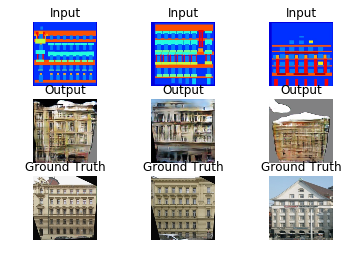

[Epoch 2000/2000]  [D loss: 0.115334, acc:   0%] [G loss: 8.149294] time: 3:56:37.838907


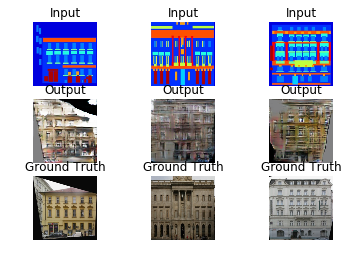

[Epoch 2000/2000]  [D loss: 0.038142, acc:   0%] [G loss: 6.018043] time: 3:56:38.750748


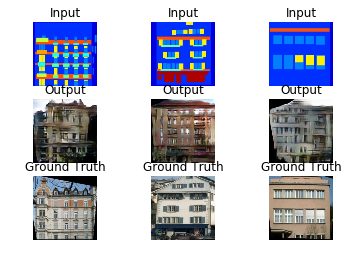

[Epoch 2000/2000]  [D loss: -0.018755, acc:   0%] [G loss: 5.883476] time: 3:56:39.663468


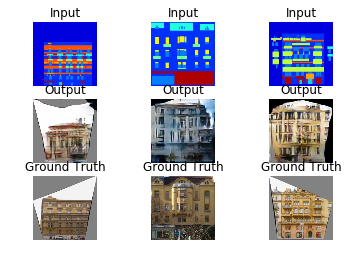

[Epoch 2000/2000]  [D loss: 0.123913, acc:   0%] [G loss: 8.916369] time: 3:56:40.553924


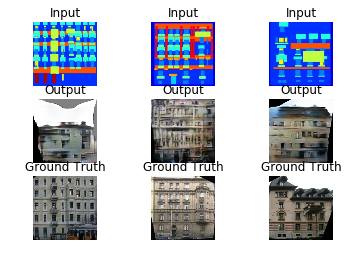

[Epoch 2000/2000]  [D loss: 0.033495, acc:   0%] [G loss: 7.960037] time: 3:56:41.479005


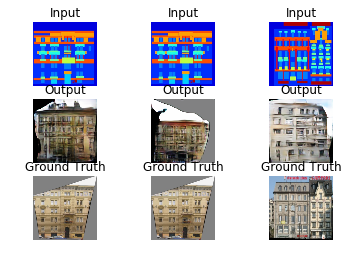

[Epoch 2000/2000]  [D loss: 0.135008, acc:   0%] [G loss: 7.880105] time: 3:56:42.377251


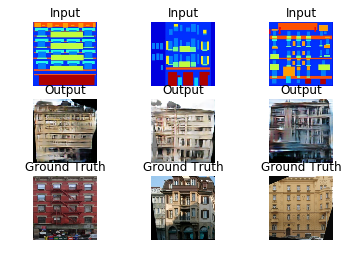

[Epoch 2000/2000]  [D loss: 0.023336, acc:   0%] [G loss: 6.963027] time: 3:56:43.283617


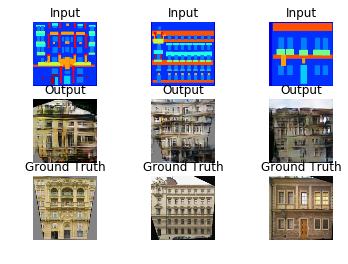

[Epoch 2000/2000]  [D loss: 0.145150, acc:   0%] [G loss: 8.710433] time: 3:56:44.188121


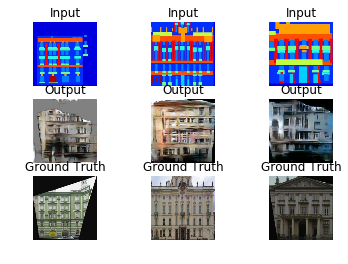

[Epoch 2000/2000]  [D loss: 0.062339, acc:   0%] [G loss: 7.400640] time: 3:56:45.104564


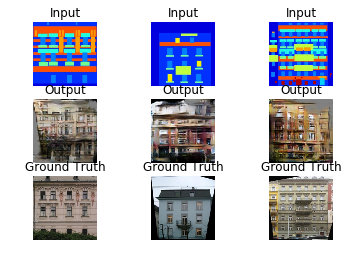

[Epoch 2000/2000]  [D loss: 0.051130, acc:   0%] [G loss: 9.239041] time: 3:56:46.024535


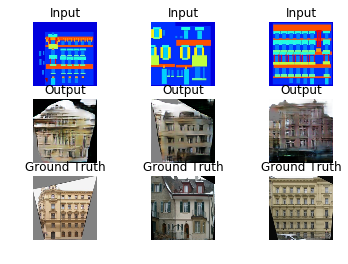

[Epoch 2000/2000]  [D loss: 0.061493, acc:   0%] [G loss: 8.550579] time: 3:56:47.118999


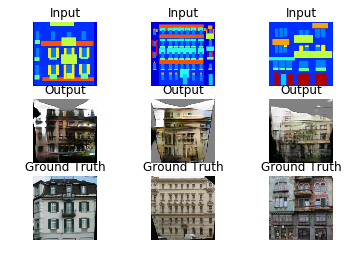

[Epoch 2000/2000]  [D loss: 0.081772, acc:   0%] [G loss: 7.949648] time: 3:56:48.046246


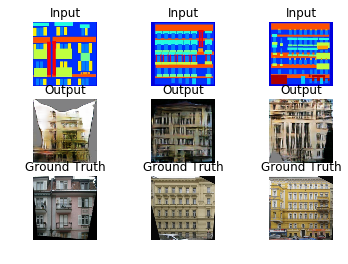

[Epoch 2000/2000]  [D loss: 0.026943, acc:   0%] [G loss: 9.014079] time: 3:56:48.959033


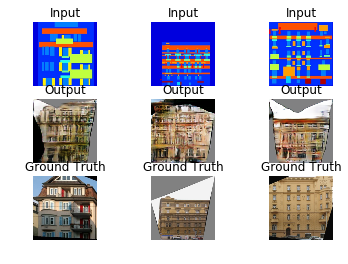

[Epoch 2000/2000]  [D loss: 0.068737, acc:   0%] [G loss: 8.691364] time: 3:56:49.876794


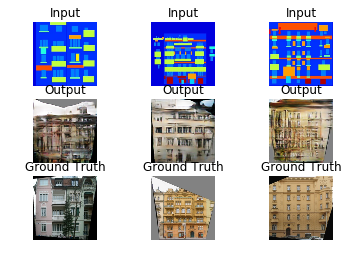

[Epoch 2000/2000]  [D loss: 0.028555, acc:   0%] [G loss: 6.053122] time: 3:56:50.804321


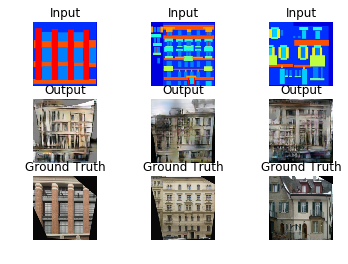

In [10]:
losses = train("facades",epochs=2000, batch_size=25, show_interval=2000)

In [11]:
print(losses)

[(0.22275695, 3.6864464), (0.16437672, 5.2555065), (0.08998747, 3.6306596), (0.1997628, 4.0190377), (0.26049572, 4.865008), (0.19478878, 3.446047), (0.111584455, 5.549589), (0.20799628, 6.2361717), (0.20615035, 4.2452235), (0.19564384, 5.9387593), (0.2413919, 6.13177), (0.08088024, 4.6082745), (0.074191496, 5.1929946), (0.2949999, 4.9314437), (0.07097356, 2.9285896), (0.033343464, 4.290672), (0.099738285, 5.5872865), (0.061663426, 5.3657556), (0.032728218, 5.9448376), (0.13648556, 6.2089663), (0.1903936, 5.886174), (0.07750632, 6.6920958), (0.06270961, 7.878789), (0.057842977, 6.112156), (0.051607545, 4.280043), (0.15258208, 6.0042963), (0.0268661, 6.6111684), (0.1311396, 7.1516614), (0.09480852, 5.5044146), (0.10172243, 4.3838587), (0.38400084, 10.230639), (0.20095149, 11.095346), (-0.0049089044, 5.624846), (0.13573673, 9.358731), (0.21266678, 8.558142), (0.037429586, 8.507193), (0.090895385, 7.667357), (0.087937415, 8.629267), (0.083821334, 7.6983833), (0.058611363, 6.318472), (0.094